In [4]:
import matplotlib.pyplot as plt
import numpy as np
from functions import *
import os
import glob
import re
import sys

sys.path.append(os.path.join(os.getcwd(), os.pardir))
from Tools.plot_utils import _plot_parameter_map_slice, _remove_ticks


from Tools.load_save_utils import load_parameter_names_units_limits, load_acquisition_reconstruction_from_nii
from Tools.colormaps import COLORMAPS, COLORNORMS

from matplotlib.axes import Axes
from matplotlib.figure import Figure
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib as mpl


import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.constrained_layout.use'] = False
mpl.rcParams['figure.dpi'] = 300


PARAMETER_DISPLAYED_LABELS, PARAMETER_UNITS, _, _, PARAMETER_LIMS_COLORMAP = load_parameter_names_units_limits(
    os.path.dirname('/data_local/data_ssd/couderth/MRF_stroke/'))

figure_color = 'white'

slice_title_kwargs = dict(fontsize=15, color=figure_color,
                          fontweight='demibold', fontfamily='serif')
param_title_kwargs = dict(fontsize=15, color=figure_color,
                          fontweight='demibold', fontfamily='serif')
figure_title_kwargs = dict(
    fontsize=25, color=figure_color, fontweight='bold', fontfamily='serif')
figure_subtitle_kwargs = dict(
    fontsize=15, color=figure_color, fontweight='demibold', fontfamily='serif')

In [5]:
roi_brain_filepath = "2021_MRF_TC/MP3_projects/MP3_MRFUSE_20240424/ROI_data/MAPIRMAGE-D00-ROI-brain2D_20240426-085037219"
path_to_ROI_brain_map = os.path.join("/data_network/summer_projects/couderth/Current", roi_brain_filepath)
ROI_brain, _, _ =  load_acquisition_reconstruction_from_nii(path_to_ROI_brain_map, nb_indents=1, v=False)
ROI_brain = np.rot90(ROI_brain)

In [7]:
#PARAMETERS :

'''
global_path = "/data_network/summer_projects/couderth/Current/2023_MRF_Collab/Lila/tests_cg_sense/reco_parameter_maps/"

#matching_reference = os.path.join(global_path, 'Matching/Matching_Philips_FS_ref_dicoTom_2500distrib.npy')
matching_reference = os.path.join(global_path, 'MARVEL/MARVEL_Philips_FS_ref.npy')
matching_reference = np.load(matching_reference)

for pulse in [200] : 
    for spirals in ['turning', 'fixed'] :
        for alpha in [1,2,4, 'Philips'] : 
            reconstruction = []

            path_pulse = global_path + 'MARVEL/without_auto_encoder/' + str(pulse) + 'p'

            if spirals == 'turning' :
                global_reconstruction_path = os.path.join(path_pulse, 'turning_spirals')

            else :
                global_reconstruction_path = os.path.join(path_pulse, 'fixed_spirals')

            if alpha!='Philips' : 
                file_name = 'reco_MARVEL_alpha' + str(alpha)  +'*'
                file_name_RECO = "reco_MARVEL_alpha" + str(alpha) +".png"
                file_name_diff = "diff_MARVEL_alpha" + str(alpha) +".png"
                file_name_stat = "stat_MARVEL_alpha" + str(alpha) +".png"
                subtitle =f"For {spirals} spirals with alpha = {alpha} and {pulse} pulses"

            else :
                file_name = 'reco_MARVEL_Philips*'  
                file_name_RECO = "reco_MARVEL_Philips.png" 
                file_name_diff = "diff_MARVEL_Philips.png" 
                file_name_stat = "stat_MARVEL_Philips.png" 
                subtitle =f"For {spirals} spirals from Philips and {pulse} pulses"


            files = sorted(glob.glob(os.path.join(global_reconstruction_path, file_name)), key=lambda name: int(''.join([c for c in name if c.isdigit()])))

            for i, reconstruction_path in enumerate (files):

                reconstruction.append(np.load(reconstruction_path))

            path_save = global_reconstruction_path + "/figures"
            path_save_reco = os.path.join(path_save, file_name_RECO)
            path_save_diff= os.path.join(path_save, file_name_diff)
            path_save_stat= os.path.join(path_save, file_name_stat)

            #Check that all the acq are loaded

            if len(reconstruction) != 13 :
                warnings.warn(f"Only {len(reconstruction)} are loaded")

            reconstruction_all = np.transpose(np.squeeze(np.asarray(reconstruction)), axes = (1,2,3,0))
            label_parameters = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']


            slice_titles = []
            for i in range (len(reconstruction)) : 
                if i==0:
                    slice_titles.append(str(i+1) + " SHOT")
                else :
                    slice_titles.append(str(i+1) + " SHOTS")

            fig_param = plot_parameter_maps_several_slices2(reconstruction_all, label_parameters, fig_size=(15.5,32), subtitle = subtitle, slice_titles=slice_titles)
            plt.savefig(path_save_reco)

            list_indicator = []

            list_pre_sum = []

            for i in range (len(reconstruction)) :
                indicator=np.zeros((6,192,192))

                
                pre, diff, pre_sum = compare_pre(matching_reference, reconstruction[i])
                for j in [0,1,3,5] :
                    indicator[j,:,:] = pre[j,:,:,0]
                for j in [2,4] :
                    indicator[j,:,:] = diff[j,:,:,0]
                
                list_indicator.append(indicator)

                list_pre_sum.append(pre_sum)


            PRE_all = np.transpose(np.squeeze(np.asarray(list_indicator)), axes = (1,2,3,0))
            fig_marvel = plot_parameter_maps_several_slices_stat(PRE_all, label_parameters,fig_size=(15.5,32), slice_titles=slice_titles, title='MARVEL', subtitle =subtitle )

            plt.savefig(path_save_diff)

            horizontal_size = 20  
            vertical_size = 12  


            fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(horizontal_size, vertical_size))
            ROI_brain_bool = ROI_brain.astype(bool)


            fig.suptitle("Statistics MARVEL reconstruction \n ",x=0.5, y=0.15, **figure_title_kwargs) 
            fig.text(0.5,0.10,subtitle,ha='center', va='center',**figure_subtitle_kwargs)   


            plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.22,hspace=0.3, wspace=0.3)


            for i in range(6):

                data = [np.abs(PRE_all[i, ROI_brain_bool, j]).flatten() for j in range(len(reconstruction))]
            
                ax[i // 3, i % 3].boxplot(data, sym='')

            
                ax[i // 3, i % 3].scatter([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], np.asarray(list_pre_sum / np.sum(ROI_brain))[:, i])

                
                ax[i // 3, i % 3].set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

                ax[i // 3, i % 3].set_xlabel("Number of shots")
                
                param_title = PARAMETER_DISPLAYED_LABELS[label_parameters[i]]
                if PARAMETER_UNITS[label_parameters[i]] != '':
                    param_title += ' (' + PARAMETER_UNITS[label_parameters[i]] + ')'

                ax[i // 3, i % 3].set_title(param_title,**param_title_kwargs)

                if i == 2 or i == 4:
                    ax[i // 3, i % 3].set_ylabel("Absolute difference")
                else:
                    ax[i // 3, i % 3].set_ylabel("Percentage relative error (%)")

            plt.savefig(path_save_stat)
            '''

'\nglobal_path = "/data_network/summer_projects/couderth/Current/2023_MRF_Collab/Lila/tests_cg_sense/reco_parameter_maps/"\n\n#matching_reference = os.path.join(global_path, \'Matching/Matching_Philips_FS_ref_dicoTom_2500distrib.npy\')\nmatching_reference = os.path.join(global_path, \'MARVEL/MARVEL_Philips_FS_ref.npy\')\nmatching_reference = np.load(matching_reference)\n\nfor pulse in [200] : \n    for spirals in [\'turning\', \'fixed\'] :\n        for alpha in [1,2,4, \'Philips\'] : \n            reconstruction = []\n\n            path_pulse = global_path + \'MARVEL/without_auto_encoder/\' + str(pulse) + \'p\'\n\n            if spirals == \'turning\' :\n                global_reconstruction_path = os.path.join(path_pulse, \'turning_spirals\')\n\n            else :\n                global_reconstruction_path = os.path.join(path_pulse, \'fixed_spirals\')\n\n            if alpha!=\'Philips\' : \n                file_name = \'reco_MARVEL_alpha\' + str(alpha)  +\'*\'\n                file_

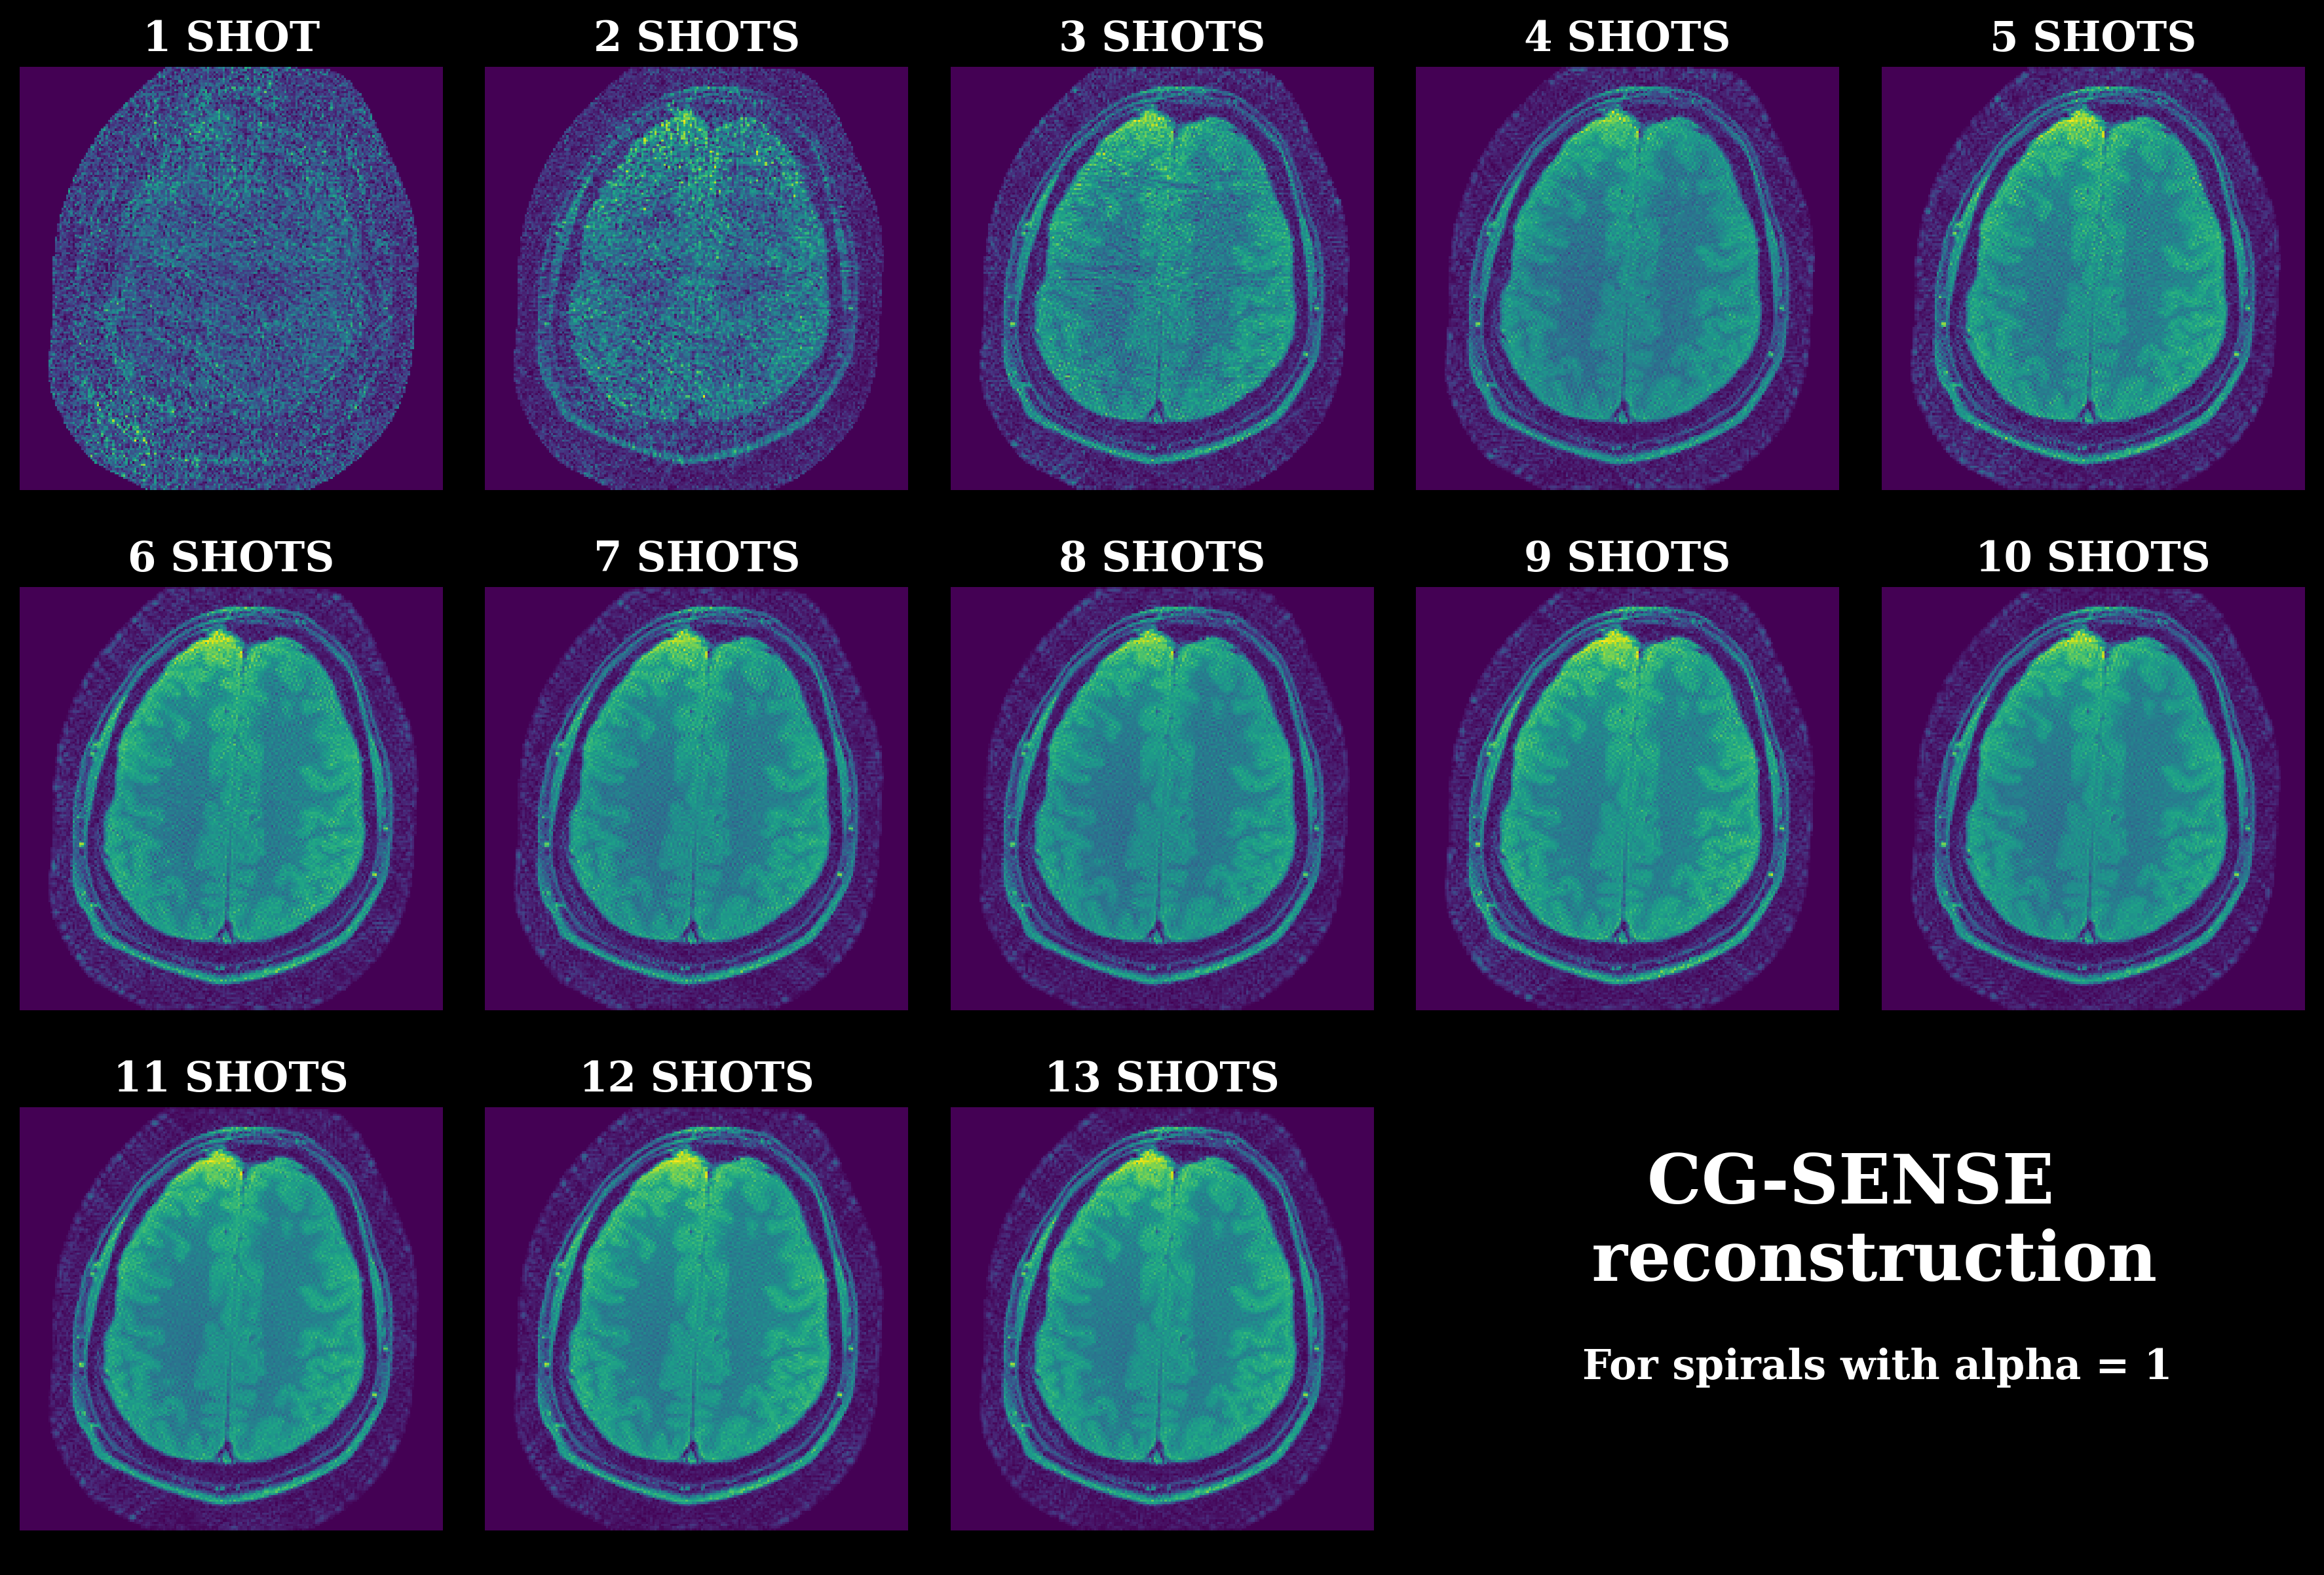

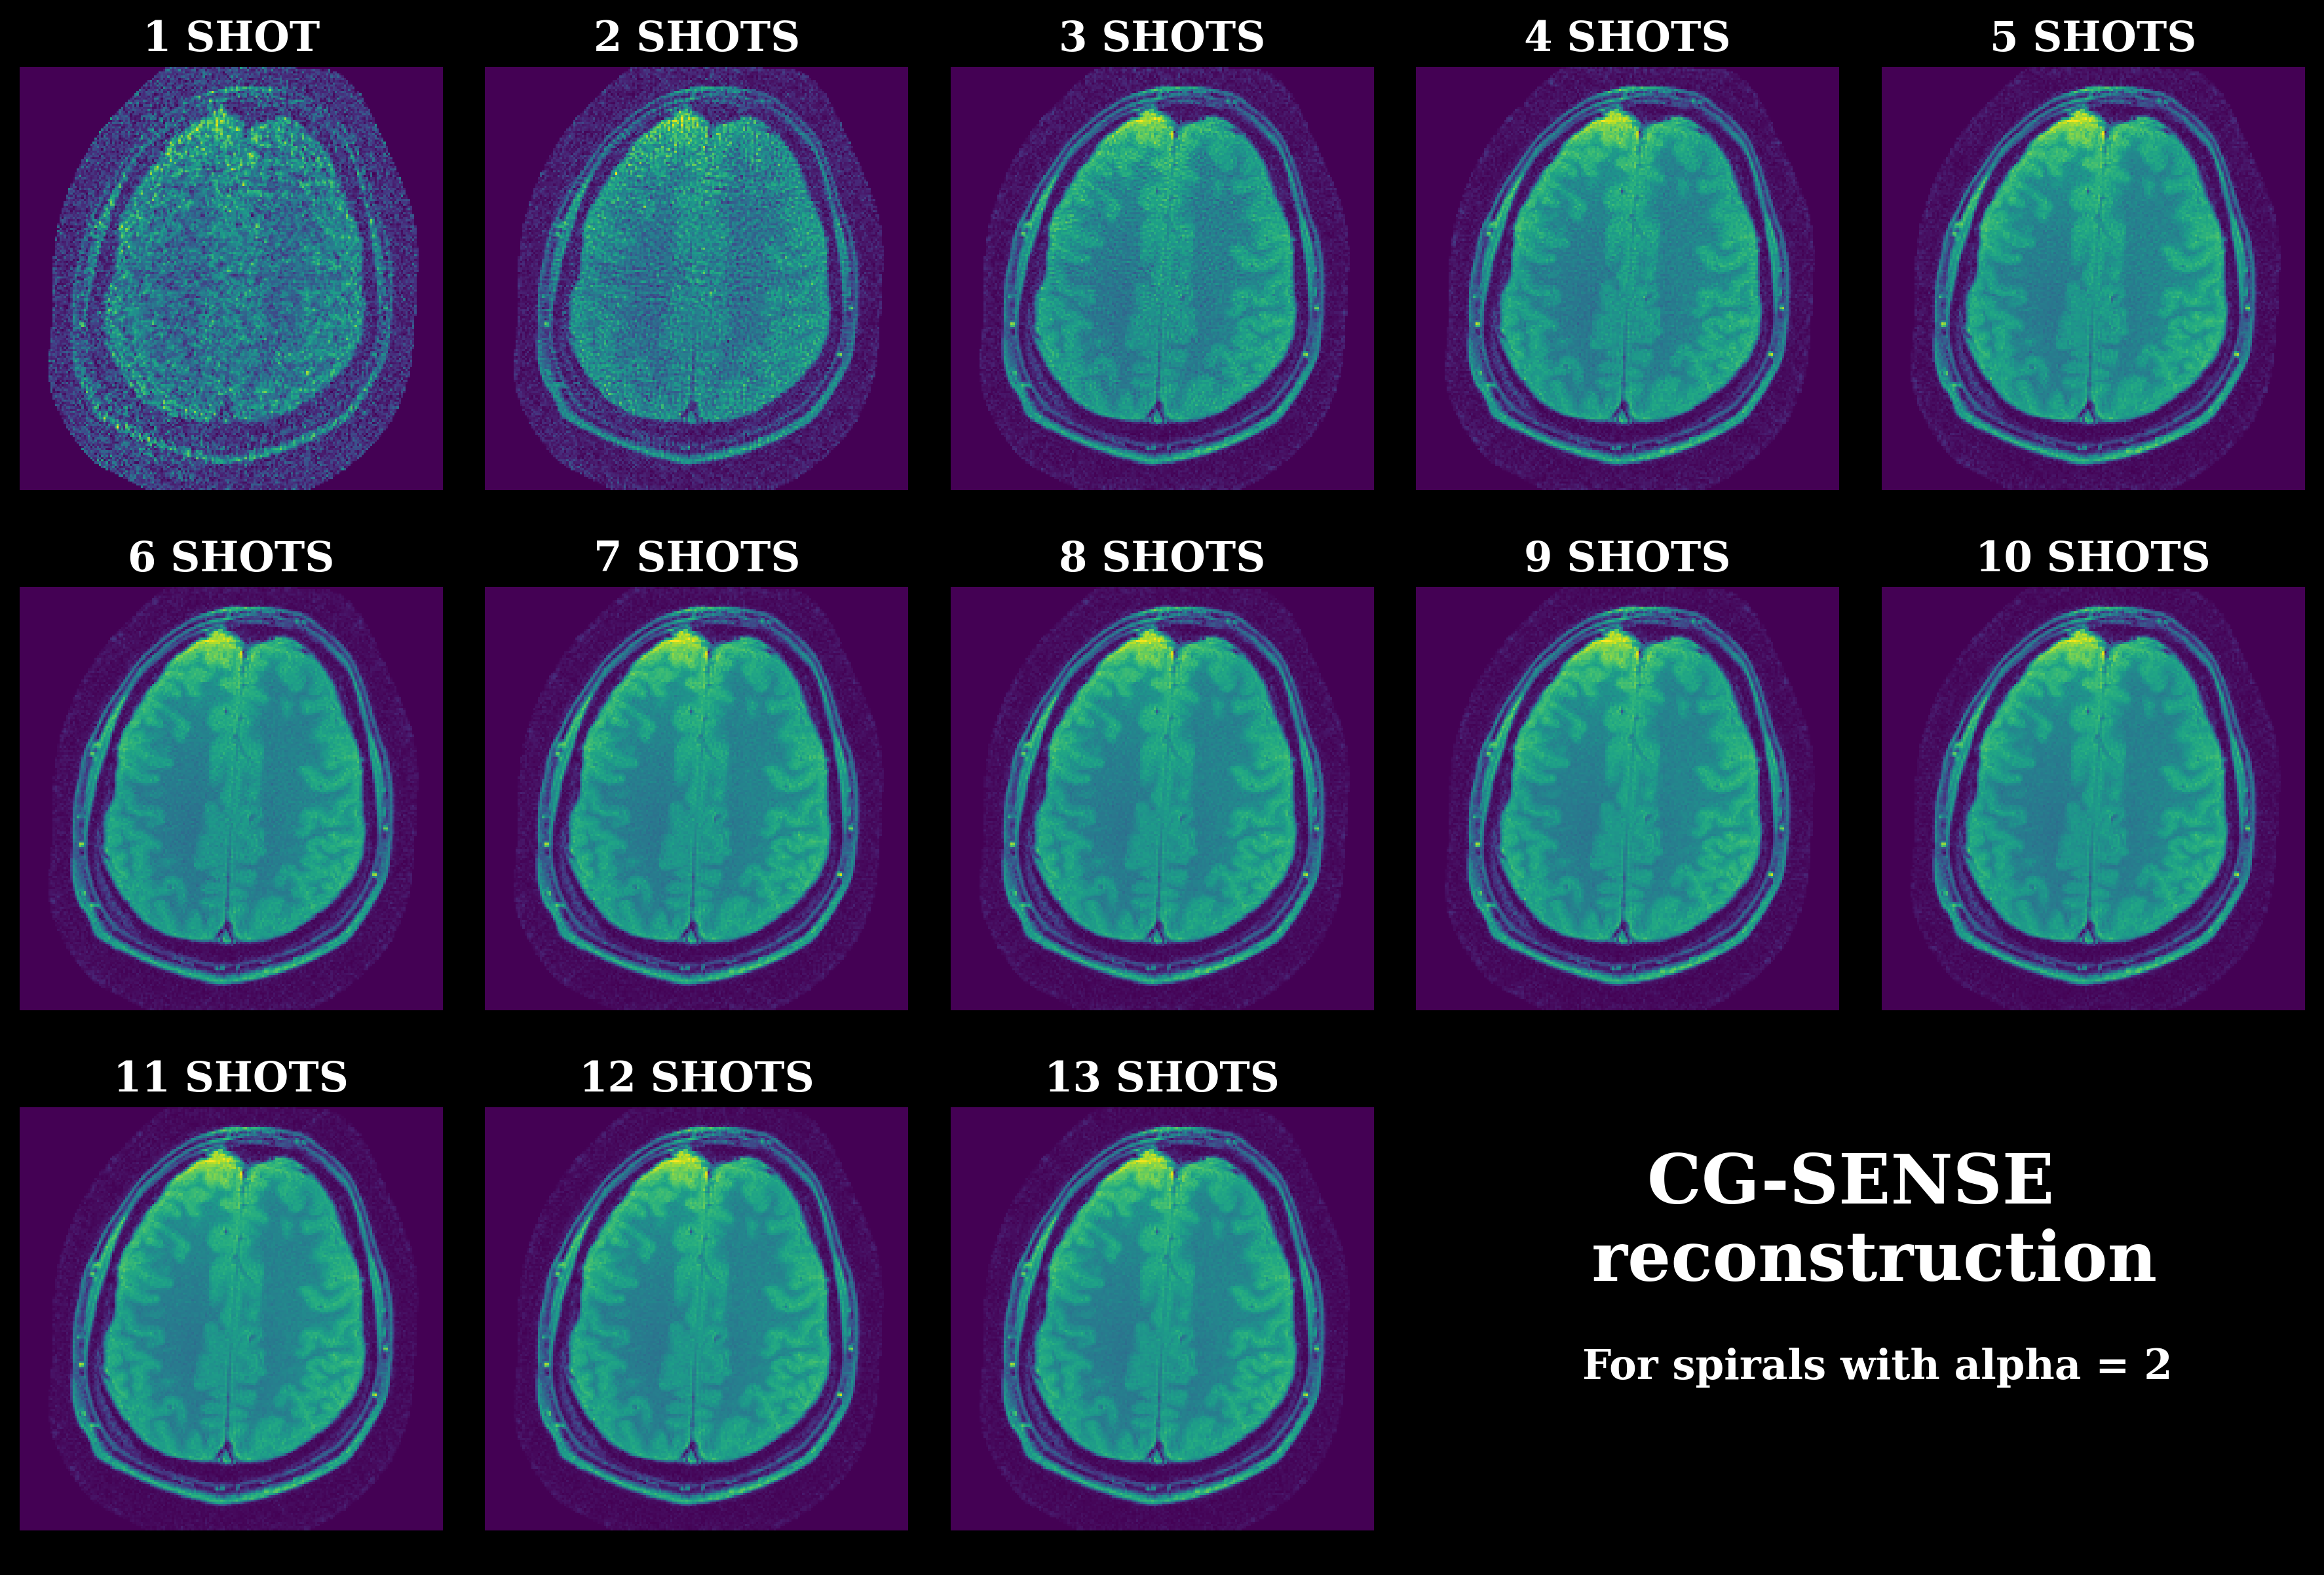

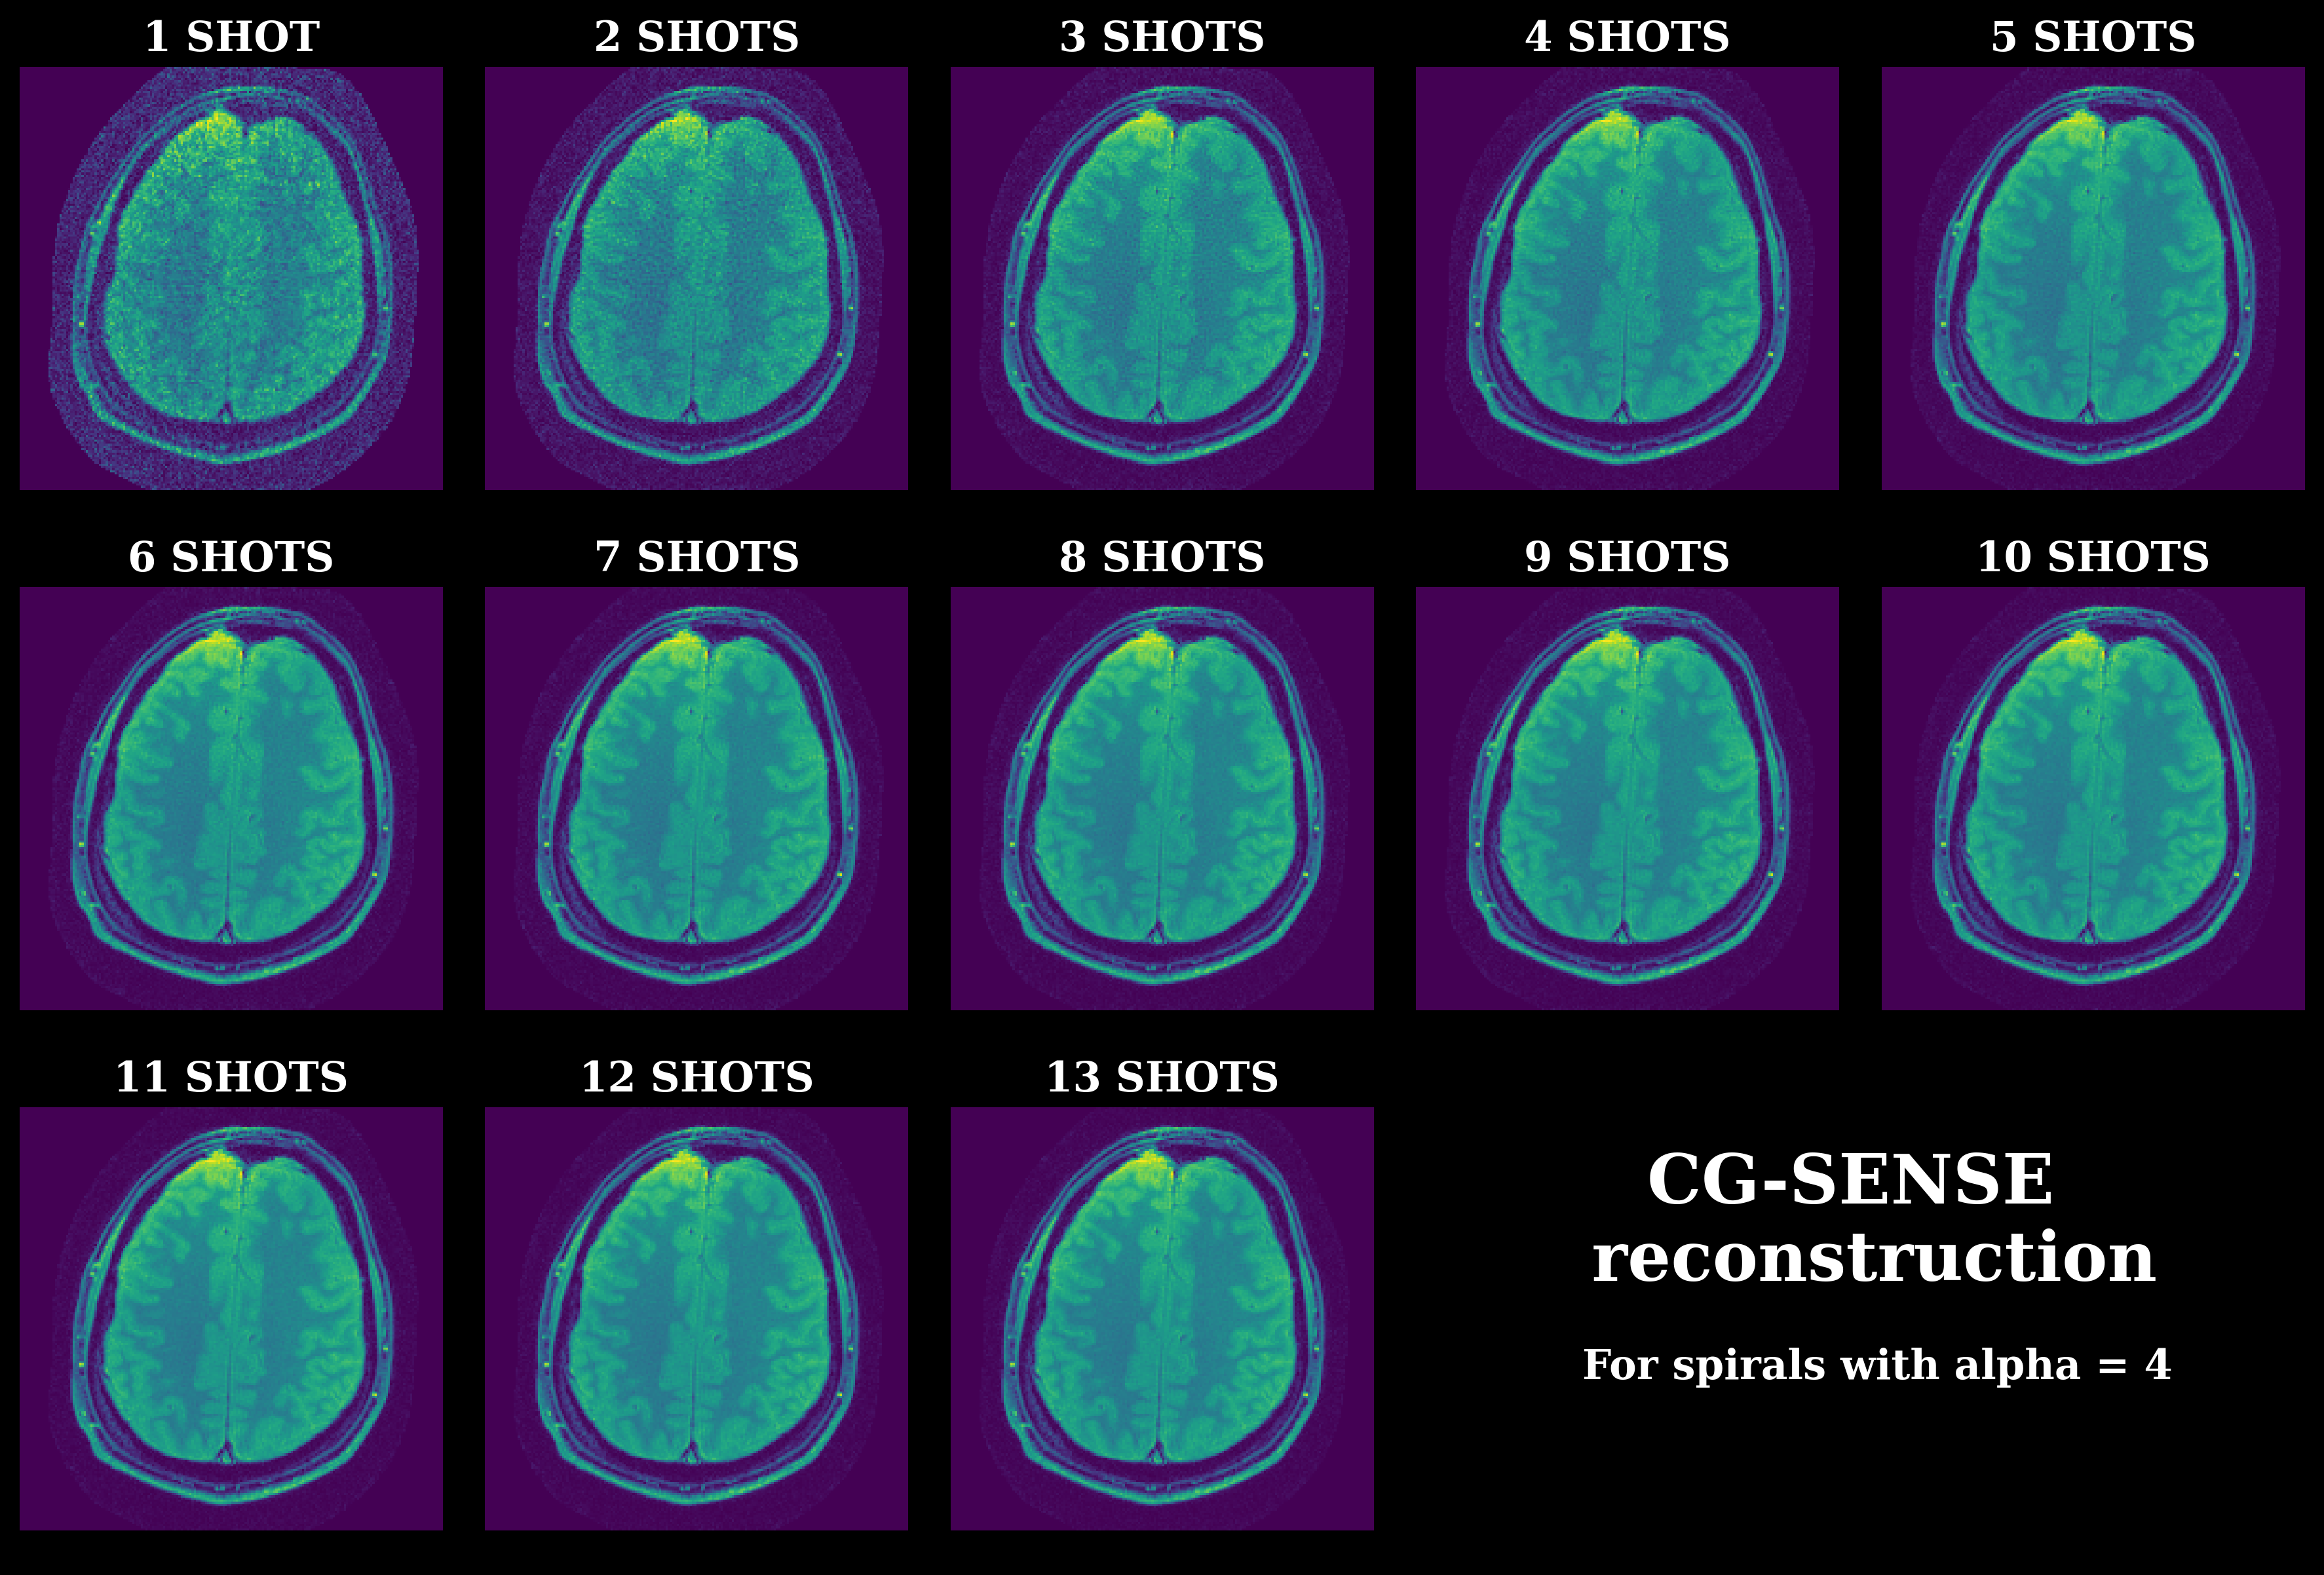

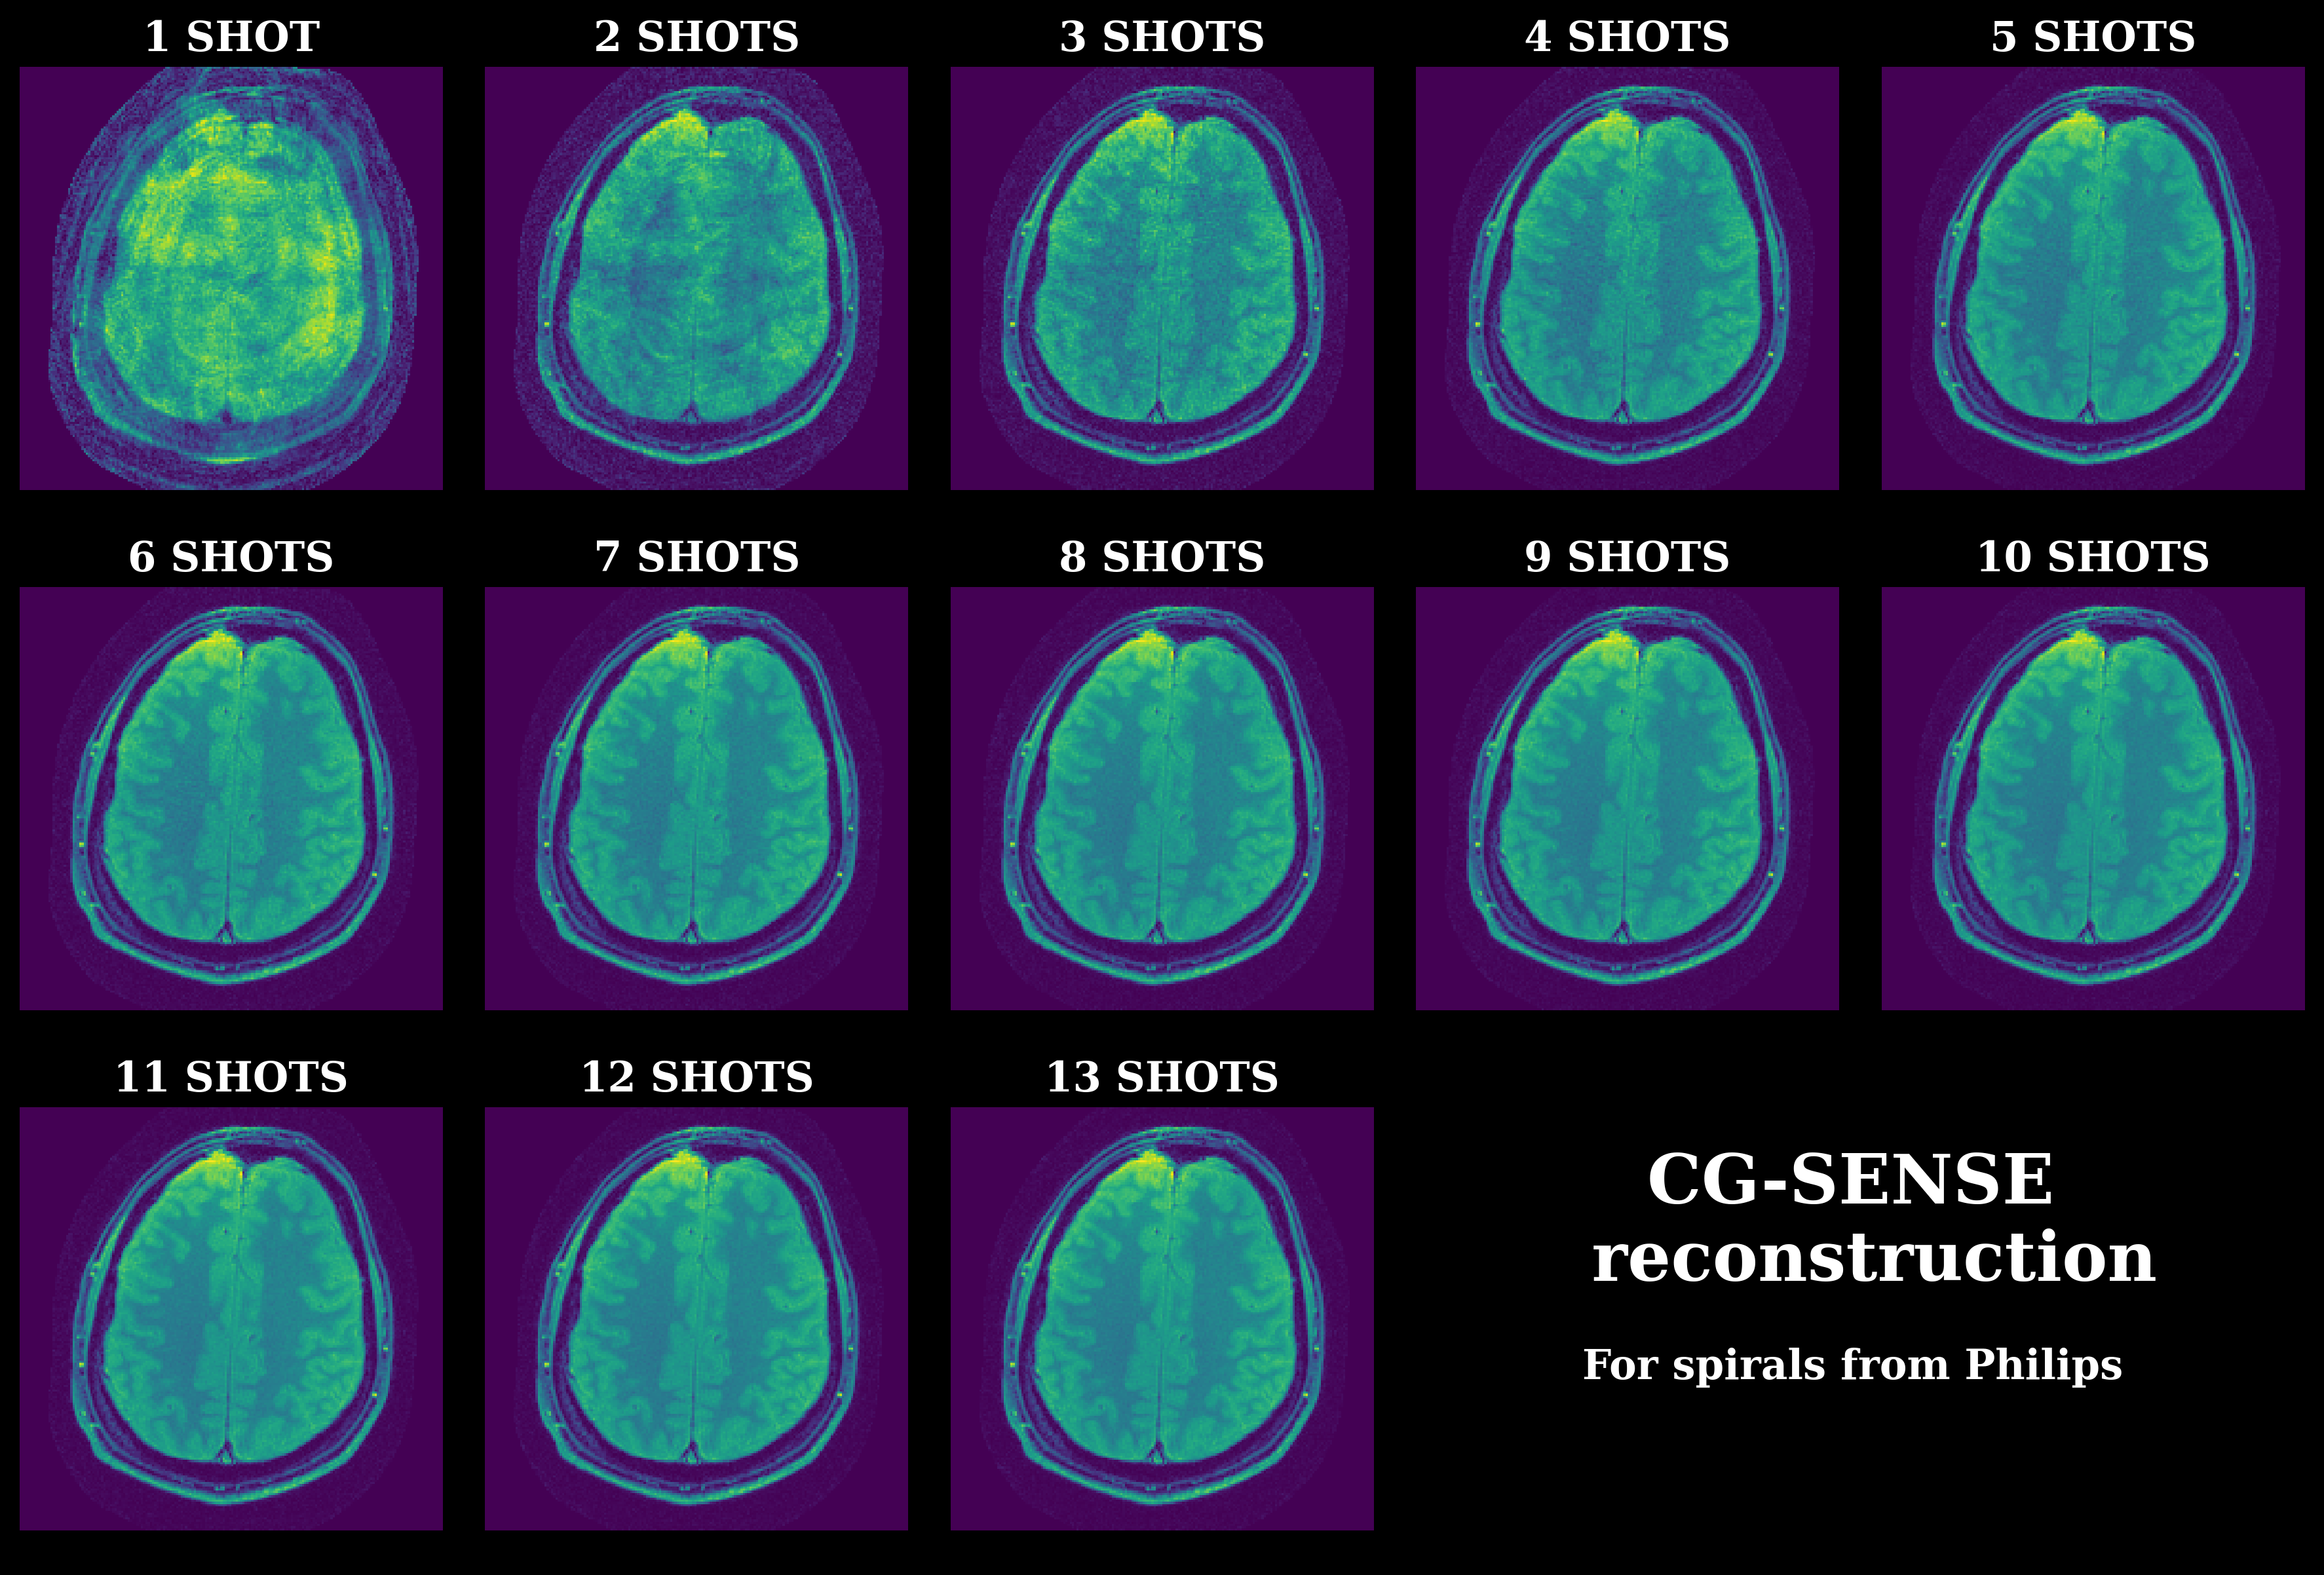

In [69]:
# RECONSTRUCTION

global_path = "/data_network/summer_projects/couderth/Current/2023_MRF_Collab/Lila/tests_cg_sense/reco_acquisitions/reco_cg_sense"

spirals = 'fixed'

for alpha in [1,2,4,'Philips'] :
    reconstruction=[]
    if spirals == 'turning' :
        global_reconstruction_path = os.path.join(global_path, 'turning_spirals')

    else :
        global_reconstruction_path = os.path.join(global_path, 'fixed_spirals')

    if alpha!='Philips' : 
        file_name = 'reco_cg_sense_alpha' + str(alpha)  +'*'
        file_name_RECO = "reco_cg_sense_alpha" + str(alpha) +".png"

        subtitle =f"For spirals with alpha = {alpha}"

    else :
        file_name = 'reco_cg_sense_Philips*'  
        file_name_RECO = "reco_cg_sense_Philips.png" 

        subtitle =f"For spirals from Philips"


    files = sorted(glob.glob(os.path.join(global_reconstruction_path, file_name)), key=lambda name: int(''.join([c for c in name if c.isdigit()])))

    for i, reconstruction_path in enumerate (files):

        reconstruction.append(np.load(reconstruction_path))

    path_save = global_reconstruction_path + "/figures"
    path_save_reco = os.path.join(path_save, file_name_RECO)

    reconstruction_pulse = [reco[0,:,:] for reco in reconstruction]

    # Définir le nombre de colonnes (par exemple, 4 colonnes) et calculer le nombre de lignes
    n_cols = 5
    n_rows = 3 # Arrondi vers le haut

    slice_titles = []
    for i in range (len(reconstruction)) : 
        if i==0:
            slice_titles.append(str(i+1) + " SHOT")
        else :
            slice_titles.append(str(i+1) + " SHOTS")

    # Créer la figure et les axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

    # Supprimer les axes inutilisés (si le nombre d'images n'est pas divisible par n_cols)
    for i in range(15):
        if i<13 :
            ax = axes.flat[i]
            im = ax.imshow(np.rot90(np.abs(reconstruction_pulse[i]), -1))  # Afficher l'image
            ax.set_title(slice_titles[i], **slice_title_kwargs)  # Ajouter un titre
            ax.axis("off")  # Supprimer les axes
        else:
            axes.flat[i].axis("off")  # Désactiver les axes restants

    fig.text(0.75, 0.25,"CG-SENSE \n reconstruction", ha='center', **figure_title_kwargs) 
    fig.text(0.655,0.2,subtitle,**figure_subtitle_kwargs) 
    # Ajuster les marges entre les images
    plt.subplots_adjust(wspace=0.1, hspace=0.1) 
    plt.savefig(path_save_reco)
    

In [67]:
# RECONSTRUCTION SOS
'''
global_path = "/data_network/summer_projects/couderth/Current/2023_MRF_Collab/Lila/tests_cg_sense/reco_acquisitions/reco_sos"

spirals = 'fixed'
alpha=4

reconstruction=[]

global_reconstruction_path = os.path.join(global_path, 'fixed_spirals')


file_name = 'reco_sos_alpha4*'  
file_name_RECO = "reco_sos_alpha4.png" 

subtitle =f"For spirals with alpha = 4"


files = glob.glob(os.path.join(global_reconstruction_path, file_name))
reconstruction = np.load(files[0])

path_save = global_reconstruction_path + "/figures"
path_save_reco = os.path.join(path_save, file_name_RECO)

reconstruction_pulse = [reco[0,0,:,:] for reco in reconstruction]


# Définir le nombre de colonnes (par exemple, 4 colonnes) et calculer le nombre de lignes
n_cols = 5
n_rows = 3 # Arrondi vers le haut

slice_titles = []
for i in range (len(reconstruction)) : 
    if i==0:
        slice_titles.append(str(i+1) + " SHOT")
    else :
        slice_titles.append(str(i+1) + " SHOTS")

# Créer la figure et les axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Supprimer les axes inutilisés (si le nombre d'images n'est pas divisible par n_cols)
for i in range(15):
    if i<13 :
        ax = axes.flat[i]
        im = ax.imshow(np.rot90(np.abs(reconstruction_pulse[i]), -1))  # Afficher l'image
        ax.set_title(slice_titles[i], **slice_title_kwargs)  # Ajouter un titre
        ax.axis("off")  # Supprimer les axes
    else:
        axes.flat[i].axis("off")  # Désactiver les axes restants

fig.text(0.75, 0.25,"SOS \n reconstruction", ha='center', **figure_title_kwargs) 
fig.text(0.655,0.2,subtitle,**figure_subtitle_kwargs) 
# Ajuster les marges entre les images
plt.subplots_adjust(wspace=0.1, hspace=0.1) 
plt.savefig(path_save_reco)
'''